## Using a custom BoTorch model with Ax

In this tutorial, we illustrate how to use a custom BoTorch model within Ax's `botorch_modular` API. This allows us to harness the convenience of Ax for running Bayesian Optimization loops, while at the same time maintaining full flexibility in terms of the modeling.

Acquisition functions and strategies for optimizing acquisitions can be swapped out in much the same fashion. See for example the tutorial for [Implementing a custom acquisition function](./custom_acquisition).

If you want to do something non-standard, or would like to have full insight into every aspect of the implementation, please see [this tutorial](./closed_loop_botorch_only) for how to write your own full optimization loop in BoTorch.

Next cell sets up a decorator solely to speed up the testing of the notebook. You can safely ignore this cell and the use of the decorator throughout the tutorial.

In [1]:
import os
from contextlib import contextmanager

from ax.utils.testing.mock import fast_botorch_optimize_context_manager
import plotly.io as pio
# Ax uses Plotly to produce interactive plots. These are great for viewing and analysis,
# though they also lead to large file sizes, which is not ideal for files living in GH.
# Changing the default to `png` strips the interactive components to get around this.
pio.renderers.default = "png"

SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_EVALS = 10 if SMOKE_TEST else 30


@contextmanager
def dummy_context_manager():
    yield


if SMOKE_TEST:
    fast_smoke_test = fast_botorch_optimize_context_manager
else:
    fast_smoke_test = dummy_context_manager

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


### Implementing the custom model

For this tutorial, we implement a very simple gpytorch Exact GP Model that uses an RBF kernel (with ARD) and infers a (homoskedastic) noise level.

Model definition is straightforward - here we implement a gpytorch `ExactGP` that also inherits from `GPyTorchModel` -- this adds all the api calls that botorch expects in its various modules. 

*Note:* botorch also allows implementing other custom models as long as they follow the minimal `Model` API. For more information, please see the [Model Documentation](../docs/models).

In [2]:
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils.containers import TrainingData
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP


class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    @classmethod
    def construct_inputs(cls, training_data: TrainingData, **kwargs):
        r"""Construct kwargs for the `SimpleCustomGP` from `TrainingData` and other options.

        Args:
            training_data: `TrainingData` container with data for single outcome
                or for multiple outcomes for batched multi-output case.
            **kwargs: None expected for this class.
        """
        return {"train_X": training_data.X, "train_Y": training_data.Y}

### Instantiate a `BoTorchModel` in Ax

A `BoTorchModel` in Ax encapsulates both the surrogate (commonly referred to as `Model` in BoTorch) and an acquisition function. Here, we will only specify the custom surrogate and let Ax choose the default acquisition function.

Most models should work with the base `Surrogate` in Ax, except for BoTorch `ModelListGP`, which works with `ListSurrogate`.
Note that the `Model` (e.g., the `SimpleCustomGP`) must implement `construct_inputs`, as this is used to construct the inputs required for instantiating a `Model` instance from the experiment data.

In case the `Model` requires a complex set of arguments that cannot be constructed using a `construct_inputs` method, one can initialize the `model` and supply it via `Surrogate.from_botorch(model=model, mll_class=<Optional>)`, replacing the `Surrogate(...)` below.

In [3]:
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate


ax_model = BoTorchModel(
    surrogate=Surrogate(
        # The model class to use
        botorch_model_class=SimpleCustomGP,
        # Optional, MLL class with which to optimize model parameters
        # mll_class=ExactMarginalLogLikelihood,
        # Optional, dictionary of keyword arguments to model constructor
        # model_options={}
    ),
    # Optional, acquisition function class to use - see custom acquisition tutorial
    # botorch_acqf_class=qExpectedImprovement,
)

### Combine with a `ModelBridge`

`Model`s in Ax require a `ModelBridge` to interface with `Experiment`s. A `ModelBridge` takes the inputs supplied by the `Experiment` and converts them to the inputs expected by the `Model`. For a `BoTorchModel`, we use `TorchModelBridge`. The usage is as follows:

```
from ax.modelbridge import TorchModelBridge
model_bridge = TorchModelBridge(
    experiment: Experiment,
    search_space: SearchSpace,
    data: Data,
    model: TorchModel,
    transforms: List[Type[Transform]],
    # And additional optional arguments.
)
# To generate a trial
trial = model_bridge.gen(1)
```

For Modular BoTorch interface, we can combine the creation of the `BoTorchModel` and the `TorchModelBridge` into a single step as follows:

```
from ax.modelbridge.registry import Models
model_bridge = Models.BOTORCH_MODULAR(
    experiment=experiment,
    data=data,
    surrogate=Surrogate(SimpleCustomGP),  # Optional, will use default if unspecified
    # Optional, will use default if unspecified
    # botorch_acqf_class=qNoisyExpectedImprovement,  
)
# To generate a trial
trial = model_bridge.gen(1)
```


# Using the custom model in Ax to optimize the Branin function

We will demonstrate this with both the Service API (simpler, easier to use) and the Developer API (advanced, more customizable).

## Optimization with the Service API

A detailed tutorial on the Service API can be found [here](https://ax.dev/tutorials/gpei_hartmann_service.html).

In order to customize the way the candidates are created in Service API, we need to construct a new `GenerationStrategy` and pass it into `AxClient`.

In [4]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models


gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=5,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP),
            },
        ),
    ]
)

### Setting up the experiment

In order to use the `GenerationStrategy` we just created, we will pass it into the `AxClient`.

In [5]:
import torch
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from botorch.test_functions import Branin


# Initialize the client - AxClient offers a convenient API to control the experiment
ax_client = AxClient(generation_strategy=gs)
# Setup the experiment
ax_client.create_experiment(
    name="branin_test_experiment",
    parameters=[
        {
            "name": "x1",
            "type": "range",
            # It is crucial to use floats for the bounds, i.e., 0.0 rather than 0.
            # Otherwise, the parameter would be inferred as an integer range.
            "bounds": [-5.0, 10.0],
        },
        {
            "name": "x2",
            "type": "range",
            "bounds": [0.0, 15.0],
        },
    ],
    objectives={
        "branin": ObjectiveProperties(minimize=True),
    },
)
# Setup a function to evaluate the trials
branin = Branin()


def evaluate(parameters):
    x = torch.tensor([[parameters.get(f"x{i+1}") for i in range(2)]])
    # In our case, standard error is 0, since we are computing a synthetic function.
    # Our custom model does not utilize the SEM, so this (passing 0) has no effect.
    return {"branin": (branin(x).item(), 0.0)}

[INFO 03-10 14:59:27] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 03-10 14:59:27] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-10 14:59:27] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-10 14:59:27] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x1', parameter_type=FLOAT, range=[-5.0, 10.0]), RangeParameter(name='x2', parameter_type=FLOAT, range=[0.0, 15.0])], parameter_constraints=[]).


### Running the BO loop

In [6]:
with fast_smoke_test():
    for i in range(NUM_EVALS):
        parameters, trial_index = ax_client.get_next_trial()
        # Local evaluation here can be replaced with deployment to external system.
        ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 03-10 14:59:27] ax.service.ax_client: Generated new trial 0 with parameters {'x1': -2.913243, 'x2': 10.215905}.
[INFO 03-10 14:59:27] ax.service.ax_client: Completed trial 0 with data: {'branin': (2.948595, 0.0)}.
[INFO 03-10 14:59:27] ax.service.ax_client: Generated new trial 1 with parameters {'x1': 3.529268, 'x2': 7.007559}.
[INFO 03-10 14:59:27] ax.service.ax_client: Completed trial 1 with data: {'branin': (26.26545, 0.0)}.
[INFO 03-10 14:59:27] ax.service.ax_client: Generated new trial 2 with parameters {'x1': 4.171125, 'x2': 12.343171}.
[INFO 03-10 14:59:27] ax.service.ax_client: Completed trial 2 with data: {'branin': (120.274452, 0.0)}.
[INFO 03-10 14:59:27] ax.service.ax_client: Generated new trial 3 with parameters {'x1': -4.481017, 'x2': 1.032181}.
[INFO 03-10 14:59:27] ax.service.ax_client: Completed trial 3 with data: {'branin': (223.698273, 0.0)}.
[INFO 03-10 14:59:27] ax.service.ax_client: Generated new trial 4 with parameters {'x1': 9.491165, 'x2': 0.916868}.
[INF

### Viewing the evaluated trials

In [7]:
ax_client.get_trials_data_frame()

branin  trial_index arm_name         x1         x2 trial_status  \
0     2.948595            0      0_0  -2.913243  10.215905    COMPLETED   
3    26.265450            1      1_0   3.529268   7.007559    COMPLETED   
15  120.274452            2      2_0   4.171125  12.343171    COMPLETED   
23  223.698273            3      3_0  -4.481017   1.032181    COMPLETED   
24    3.026299            4      4_0   9.491165   0.916868    COMPLETED   
25   17.508297            5      5_0  -5.000000  15.000000    COMPLETED   
26   23.640862            6      6_0   6.786102   3.435095    COMPLETED   
27   46.111996            7      7_0  -5.000000  11.409105    COMPLETED   
28   23.667770            8      8_0  -1.835937  13.380352    COMPLETED   
29    4.300844            9      9_0  10.000000   4.538439    COMPLETED   
1    22.787800           10     10_0  -0.475607   8.848061    COMPLETED   
2     2.230340           11     11_0  10.000000   2.467047    COMPLETED   
4    10.960894           12     12_0  10.000000   0.000000    COMPLETED   
5    20.649734           13     13_0   6.481131   0.000000    COMPLETED   
6    33.092632           14     14_0  10.000000   8.584130    COMPLETED   
7     6.265679           15     15_0   2.398598   1.098968    COMPLETED   
8     0.824142           16     16_0  -3.384039  13.246600    COMPLETED   
9     0.792914           17     17_0   3.331736   2.602522    COMPLETED   
10    2.158566           18     18_0   2.602749   3.365256    COMPLETED   
11    0.564630           19     19_0  -2.955167  11.850600    COMPLETED   
12    0.453757           20     20_0   9.431551   2.716621    COMPLETED   
13   30.279972           21     21_0  -0.616086   3.502067    COMPLETED   
14    0.409463           22     22_0  -3.175176  12.277354    COMPLETED   
16    0.437362           23     23_0   9.515301   2.539811    COMPLETED   
17    0.459960           24     24_0   3.219973   2.395204    COMPLETED   
18    3.678293           25     25_0  -3.689816  15.000000    COMPLETED   
19    0.528660           26     26_0  -3.291842  12.488693    COMPLETED   
20    0.424335           27     27_0  -3.072298  12.167417    COMPLETED   
21    0.414845           28     28_0   9.411261   2.336812    COMPLETED   
22    0.488084           29     29_0   3.119791   2.588569    COMPLETED   

   generation_method  
0              Sobol  
3              Sobol  
15             Sobol  
23             Sobol  
24             Sobol  
25           BoTorch  
26           BoTorch  
27           BoTorch  
28           BoTorch  
29           BoTorch  
1            BoTorch  
2            BoTorch  
4            BoTorch  
5            BoTorch  
6            BoTorch  
7            BoTorch  
8            BoTorch  
9            BoTorch  
10           BoTorch  
11           BoTorch  
12           BoTorch  
13           BoTorch  
14           BoTorch  
16           BoTorch  
17           BoTorch  
18           BoTorch  
19           BoTorch  
20           BoTorch  
21           BoTorch  
22           BoTorch

In [8]:
parameters, values = ax_client.get_best_parameters()
print(f"Best parameters: {parameters}")
print(f"Corresponding mean: {values[0]}, covariance: {values[1]}")

Best parameters: {'x1': -3.175175704962764, 'x2': 12.277353998224482}
Corresponding mean: {'branin': 0.40946292877197266}, covariance: {'branin': {'branin': 0.0}}


### Plotting the response surface and optimization progress

[INFO 03-10 14:59:45] ax.service.ax_client: Retrieving contour plot with parameter 'x1' on X-axis and 'x2' on Y-axis, for metric 'branin'. Remaining parameters are affixed to the middle of their range.


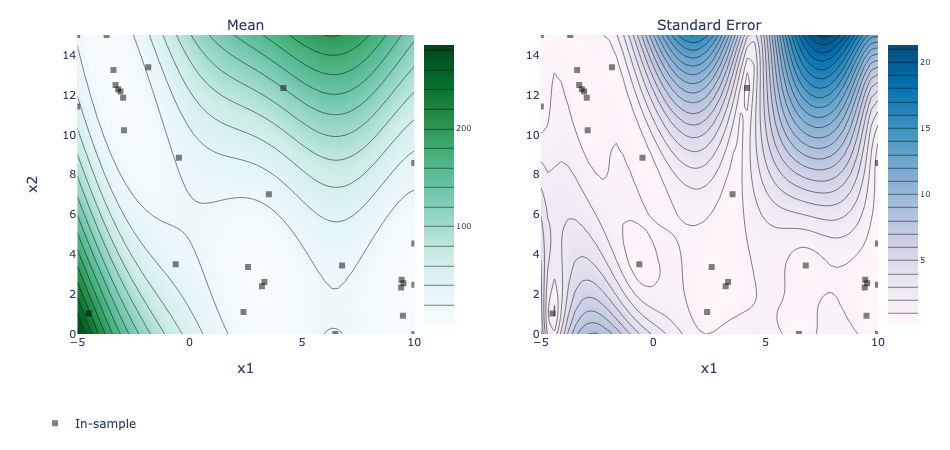

In [9]:
from ax.utils.notebook.plotting import render

render(ax_client.get_contour_plot())

In [10]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters, values[0]

({'x1': -3.175175704962764, 'x2': 12.277353998224482},
 {'branin': 0.40946292877197266})

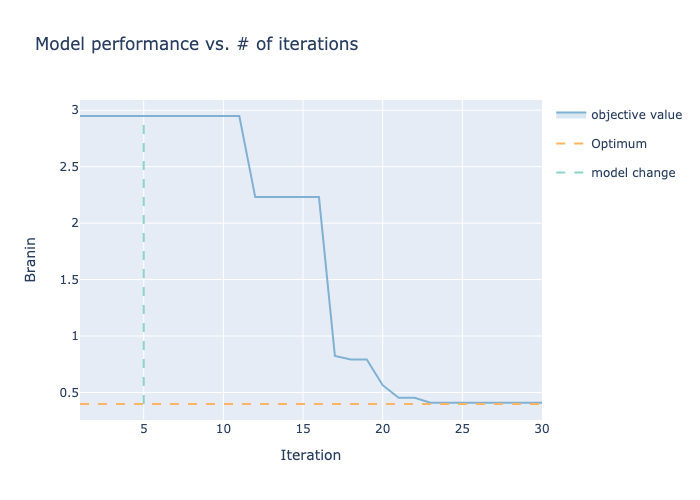

In [11]:
render(ax_client.get_optimization_trace(objective_optimum=0.397887))

## Optimization with the Developer API

A detailed tutorial on the Service API can be found [here](https://ax.dev/tutorials/gpei_hartmann_developer.html).

### Set up the Experiment in Ax

We need 3 inputs for an Ax `Experiment`:
- A search space to optimize over;
- An optimization config specifiying the objective / metrics to optimize, and optional outcome constraints;
- A runner that handles the deployment of trials. For a synthetic optimization problem, such as here, this only returns simple metadata about the trial.

In [12]:
import pandas as pd
import torch
from ax import (
    Data,
    Experiment,
    Metric,
    Objective,
    OptimizationConfig,
    ParameterType,
    RangeParameter,
    Runner,
    SearchSpace,
)
from botorch.test_functions import Branin


branin_func = Branin()

# For our purposes, the metric is a wrapper that structures the function output.
class BraninMetric(Metric):
    def fetch_trial_data(self, trial):
        records = []
        for arm_name, arm in trial.arms_by_name.items():
            params = arm.parameters
            tensor_params = torch.tensor([params["x1"], params["x2"]])
            records.append(
                {
                    "arm_name": arm_name,
                    "metric_name": self.name,
                    "trial_index": trial.index,
                    "mean": branin_func(tensor_params),
                    "sem": 0.0,  # SEM - standard error of the mean - corresponds to Yvar in BoTorch.
                }
            )
        return Data(df=pd.DataFrame.from_records(records))


# Search space defines the parameters, their types, and acceptable values.
search_space = SearchSpace(
    parameters=[
        RangeParameter(name="x1", parameter_type=ParameterType.FLOAT, lower=-5, upper=10),
        RangeParameter(name="x2", parameter_type=ParameterType.FLOAT, lower=0, upper=15),
    ]
)

optimization_config = OptimizationConfig(
    objective=Objective(
        metric=BraninMetric(name="branin_metric", lower_is_better=True),
        minimize=True,  # This is optional since we specified `lower_is_better=True`
    )
)


class MyRunner(Runner):
    def run(self, trial):
        trial_metadata = {"name": str(trial.index)}
        return trial_metadata


exp = Experiment(
    name="branin_experiment",
    search_space=search_space,
    optimization_config=optimization_config,
    runner=MyRunner(),
)

### Run the BO loop

First, we use the Sobol generator to create 5 (quasi-) random initial point in the search space. Ax controls objective evaluations via `Trial`s. 
- We generate a `Trial` using a generator run, e.g., `Sobol` below. A `Trial` specifies relevant metadata as well as the parameters to be evaluated. At this point, the `Trial` is at the `CANDIDATE` stage.
- We run the `Trial` using `Trial.run()`. In our example, this serves to mark the `Trial` as `RUNNING`. In an advanced application, this can be used to dispatch the `Trial` for evaluation on a remote server.
- Once the `Trial` is done running, we mark it as `COMPLETED`. This tells the `Experiment` that it can fetch the `Trial` data. 

A `Trial` supports evaluation of a single parameterization. For parallel evaluations, see [`BatchTrial`](https://ax.dev/docs/core.html#trial-vs-batch-trial).

In [13]:
from ax.modelbridge.registry import Models


sobol = Models.SOBOL(exp.search_space)

for i in range(5):
    trial = exp.new_trial(generator_run=sobol.gen(1))
    trial.run()
    trial.mark_completed()

Once the initial (quasi-) random stage is completed, we can use our `SimpleCustomGP` with the default acquisition function chosen by `Ax` to run the BO loop.

In [14]:
with fast_smoke_test():
    for i in range(NUM_EVALS - 5):
        model_bridge = Models.BOTORCH_MODULAR(
            experiment=exp,
            data=exp.fetch_data(),
            surrogate=Surrogate(SimpleCustomGP),
        )
        trial = exp.new_trial(generator_run=model_bridge.gen(1))
        trial.run()
        trial.mark_completed()

/Users/saitcakmak/PycharmProjects/botorch/venv/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:42: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/saitcakmak/PycharmProjects/botorch/venv/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:42: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/saitcakmak/PycharmProjects/botorch/venv/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:42: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal

/Users/saitcakmak/PycharmProjects/botorch/venv/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:42: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



View the trials attached to the `Experiment`.

In [15]:
exp.trials

{0: Trial(experiment_name='branin_experiment', index=0, status=TrialStatus.COMPLETED, arm=Arm(name='0_0', parameters={'x1': -3.0601705610752106, 'x2': 13.8101327419281})),
 1: Trial(experiment_name='branin_experiment', index=1, status=TrialStatus.COMPLETED, arm=Arm(name='1_0', parameters={'x1': 8.804318425245583, 'x2': 1.3405675208196044})),
 2: Trial(experiment_name='branin_experiment', index=2, status=TrialStatus.COMPLETED, arm=Arm(name='2_0', parameters={'x1': 6.216581170447171, 'x2': 9.557358627207577})),
 3: Trial(experiment_name='branin_experiment', index=3, status=TrialStatus.COMPLETED, arm=Arm(name='3_0', parameters={'x1': 1.9070243136957288, 'x2': 5.5254073441028595})),
 4: Trial(experiment_name='branin_experiment', index=4, status=TrialStatus.COMPLETED, arm=Arm(name='4_0', parameters={'x1': 0.38148443680256605, 'x2': 7.970501510426402})),
 5: Trial(experiment_name='branin_experiment', index=5, status=TrialStatus.COMPLETED, arm=Arm(name='5_0', parameters={'x1': 7.1571861829295

View the evaluation data about these trials.

In [16]:
exp.fetch_data().df

arm_name    metric_name        mean  sem  trial_index
0       0_0  branin_metric    3.422436  0.0            0
1       1_0  branin_metric    2.624260  0.0            1
2       2_0  branin_metric   91.133904  0.0            2
3       3_0  branin_metric   11.203099  0.0            3
4       4_0  branin_metric   25.459570  0.0            4
5       5_0  branin_metric   17.666592  0.0            5
6       6_0  branin_metric   22.774525  0.0            6
7       7_0  branin_metric   17.508297  0.0            7
8       8_0  branin_metric    9.591896  0.0            8
9       9_0  branin_metric   22.949591  0.0            9
10     10_0  branin_metric   51.824268  0.0           10
11     11_0  branin_metric    4.880301  0.0           11
12     12_0  branin_metric    2.771712  0.0           12
13     13_0  branin_metric    1.402396  0.0           13
14     14_0  branin_metric    2.787085  0.0           14
15     15_0  branin_metric    1.075676  0.0           15
16     16_0  branin_metric    7.930474  0.0           16
17     17_0  branin_metric    0.620954  0.0           17
18     18_0  branin_metric  308.129059  0.0           18
19     19_0  branin_metric    1.257142  0.0           19
20     20_0  branin_metric    0.412041  0.0           20
21     21_0  branin_metric  145.872208  0.0           21
22     22_0  branin_metric    0.848242  0.0           22
23     23_0  branin_metric    0.506163  0.0           23
24     24_0  branin_metric    0.428266  0.0           24
25     25_0  branin_metric    0.434348  0.0           25
26     26_0  branin_metric    0.479806  0.0           26
27     27_0  branin_metric    0.430536  0.0           27
28     28_0  branin_metric    0.429790  0.0           28
29     29_0  branin_metric    1.199251  0.0           29

### Plot results

We can use convenient Ax utilities for plotting the results.

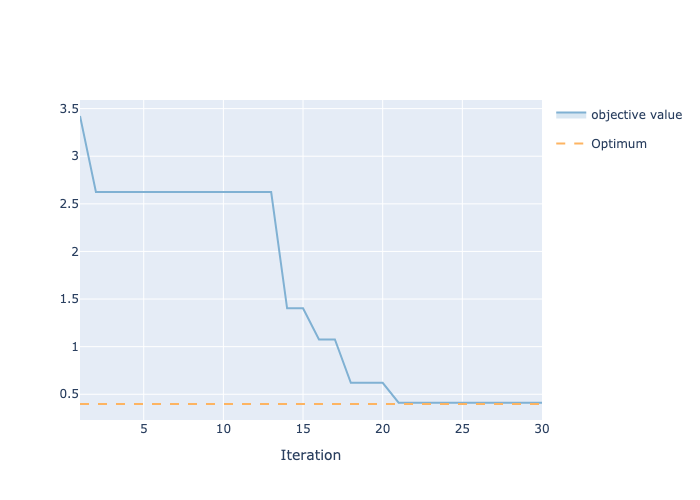

In [17]:
import numpy as np
from ax.plot.trace import optimization_trace_single_method


# `plot_single_method` expects a 2-d array of means, because it expects to average means from multiple
# optimization runs, so we wrap out best objectives array in another array.
objective_means = np.array([[trial.objective_mean for trial in exp.trials.values()]])
best_objective_plot = optimization_trace_single_method(
    y=np.minimum.accumulate(objective_means, axis=1),
    optimum=0.397887,  # Known minimum objective for Branin function.
)
render(best_objective_plot)